# 2. Local epistasis

What this module does (quick overview)

- Purpose: compute local epistasis coefficients (focal effects), pairwise interactions and general $k$-order interactions from a binary Landscape object.
- Main output: `Epistasis` objects containing:
  - values: replicate matrix per background $(M, R)$
  - mean / ci_low / ci_high: point estimates and confidence bands per background
  - std_experimental / std_biological: variability measures per background
  - backgrounds: free-locus combinations in lexicographic (MSB-first) order
  - indices / order: which loci participate and the interaction order k
  - meta: bootstrap parameters and other runtime settings
  - var_obs / var_null_median / p_value_var: null-test results (if requested)
- Key functions:
  - `epistasis_symbolic(N, idx)`: prints the alternating-sum symbolic formula for the requested interaction.
  - `focal_effect(L, i, ...)`: computes $\Delta_i F(x)$ for each background (focal effect).
  - `epistasis_k(L, indices, ...)`: computes $\varepsilon_{i_1...i_k}(x)$ (general k-order epistasis).

In many biological systems, the effect of a gene or species on a collective function depends on which others are present — a phenomenon known as epistasis. Formally, epistasis quantifies how the combined effect of multiple loci on a landscape $F(x)$ deviates from the sum of their individual effects. It thus provides a direct measure of interactions: if the joint outcome differs from what would be expected by adding up isolated effects, some interaction is at play.

This module introduces the main computational tools to quantify epistasis in binary landscapes. You will learn to:

* Compute focal effects — the effect of one locus in each background —

\begin{equation}
\Delta_i F(\mathbf{x}) = F(\mathbf{x}^i_{1}) - F(\mathbf{x}^i_{0}).
\end{equation}

* Evaluate pairwise epistasis

\begin{equation}
\varepsilon_{ij}(\mathbf{x}) = F(\mathbf{x}_{11}^{ij}) - F(\mathbf{x}_{10}^{ij}) - F(\mathbf{x}_{01}^{ij}) + F(\mathbf{x}_{00}^{ij}).
\end{equation}

* Higher-order epistatic effects 

\begin{equation}
\varepsilon_{i_1,\dots,i_k}(\mathbf{x}) 
= \sum_{\mathbf{a} \in \mathbb{F}_2^N} (-1)^{k+|\mathbf{a}|}\, F(\mathbf{x}^{i_1\dots i_k}_{a_1\dots a_k}) \; .
\end{equation}

* Generate symbolic expressions that make interaction patterns explicit.

<details>
<summary><strong>Flags and policies</strong></summary>
-------------------------------------------------------
### Important flags and policies

- missing_policy: controls behavior when a state is missing for a background.
  - "error" (default): raise an error if the complementary state is missing (e.g., xi=0 or xi=1 absent).
  - "drop": drop backgrounds that are not present in both partitions (useful with incomplete data).

- nan_policy: how to treat NaNs among replicates.
  - "omit": treat NaNs as zeros when forming alternating sums and compute means while ignoring NaNs (equivalent to imputing 0 for the sum).
  - "propagate": if all replicates for a cell are NaN, mark that background result as NaN (propagate missingness).

- Bootstrap / uncertainty:
  - B_uncertainty: number of resamples to estimate uncertainty about F̂ (yields CI and sign probabilities).
  - uncertainty_flavor: "iid" or "wildcluster" (method for perturbations).
  - multipliers: "rademacher" or "normal" for wild bootstrap multipliers.
  - B_null: number of resamples to generate null landscapes and run the variance-excess test.
  - consider_bio_corr: preserve empirical cross-state correlations when generating nulls (True) or break correlations (False).
------------------------------------------------------
</details>

## 2.1. Importing the required packages

In this tutorial, we will use:

- **`numpy`** — for numerical operations and array handling.  
- **`pandas`** — to manage and visualize tabular data.  
- **`matplotlib`** — for simple visualizations and plots.  
- **`epistasia`** — the main package used for representing and analyzing binary landscapes.

We will also define a small helper `header` function for formatted section headers, and adjust the Python path so the interpreter can find the `epistasia` package locally.

In [1]:
###########################
#         IMPORTS         #
###########################

import os
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython.display import display, HTML

from math import comb

from matplotlib import pyplot as plt
plt.style.use('./style.mplstyle') #include plotsyle

import sys

###########################
#         HELPERS         #
###########################

# Pretty printing helper
def header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

#############################################
#     LOAD BINARY LANDSCAPES DEPENDENCE     #
#############################################

#INCLUDE YOUR PATH HERE
base_path = os.path.expanduser("~/FunEcoLab_IBFG Dropbox/")
sys.path.insert(1, base_path)

#READ DATA FRAME WITH LANDSCAPE FORMAT
import epistasia as ep

## 2.2. Display symbolic epistasis coefficients

<details>
  <summary><strong>Code details: conventions and arguments</strong></summary>

  <div>

  --------------------------------------------------------------------

  **Conventions**

  - Indices are 0-based: loci are numbered $0, 1, \dots, N-1$.
  - Backgrounds are ordered lexicographically (most significant bit first).
  - The symbolic epistasis follows the biological “present − absent” sign convention:
    the first term is $+F(\dots 111 \dots)$ and signs alternate according to
    $(-1)^{k + |a|}$ for $a \in \{0,1\}^k$.
  - You can use `ep.epistasis_symbolic(N, idx)` to inspect the alternating-sum
    formula before computing numerics; this is useful to debug indexing and
    missing-state issues.

  **Function arguments**

  - **`N : int`**  
    Total number of loci in the landscape. It is used for context/sanity checks
    and to make the call explicit, but it does not change the algebraic form
    of the symbolic expression.

  - **`idx : Sequence[int]`**  
    Sequence of locus indices defining the interaction
    $\varepsilon_{i_1,\dots,i_k}(x)$.  
    The indices:
      * must be integers in the range $0 \le i < N$,
      * define the order $k = |\text{idx}|$,
      * are internally sorted (`idx = sorted(idx)`),
      * must contain at least one locus; otherwise a `ValueError` is raised.

-----------------------------------------------------

  </div>
</details>

Before computing numerical values, it is often useful to visualize how epistatic terms are defined mathematically. The function `epistasis_symbolic(N, idx)` prints the explicit alternating-sum expression that defines the epistasis coefficient $\varepsilon_{i_1,\dots,i_k}(\mathbf{x})$ for a given set of loci.

This symbolic representation helps to:

* Understand the sign convention used (“present − absent”).

* Verify that higher-order terms generalize the focal and pairwise effects correctly.

* Build intuition about how many terms and backgrounds are involved in each interaction order.

In [2]:
# N: Total number of locus in the landscape
N = 3

# Order 1 (focal effect): ε_i(x) = F(x^i_1) - F(x^i_0)
print(ep.epistasis_symbolic(N, idx=(1,)))        # ε_{1}(x) = +F(x^{1}_{1}) - F(x^{1}_{0})

# Order 2 (pair): ε_{i,j}(x) 
print(ep.epistasis_symbolic(N, idx=(0, 2)))      # ε_{0,2}(x) = +F(x^{02}_{11}) - F(x^{02}_{10}) - F(x^{02}_{01}) + F(x^{02}_{00})

# Order 3 (triplet): when N=3 there is only one possible background (2^{3-3} = 1)
print(ep.epistasis_symbolic(N, idx=(0, 1, 2)))   # ε_{0,1,2}(x) = +F(x^{012}_{111}) - F(x^{012}_{110}) - ... + F(x^{012}_{000})


ε_{1}(x) = +F(x^{1}_{1}) -F(x^{1}_{0})
ε_{0,2}(x) = +F(x^{02}_{11}) -F(x^{02}_{10}) -F(x^{02}_{01}) +F(x^{02}_{00})
ε_{0,1,2}(x) = +F(x^{012}_{111}) -F(x^{012}_{110}) -F(x^{012}_{101}) +F(x^{012}_{100}) -F(x^{012}_{011}) +F(x^{012}_{010}) +F(x^{012}_{001}) -F(x^{012}_{000})


## 2.3. Computing local epistatic coefficients 

This section turns the symbolic definitions into numeric estimates from a Landscape object. The typical workflow is:

1. Provide a Landscape ($L$) built from a DataFrame with:
   - states: binary matrix ($M$ rows × $N$ loci) describing presence/absence.
   - values: numeric replicate measurements ($M$ rows × $R$ replicates).
2. Choose the term to compute:
   - focal effect $\Delta_i F(x)$: call `ep.focal_effect(L, i, ...)`
   - general k-order $\varepsilon_{i1...ik}(x)$: call `ep.epistasis_k(L, indices=(...), ...)`
3. Tune robustness and uncertainty options (short summary below).

What the functions do (high-level)
- Align rows for the required states (e.g., $x_i=0$ vs $x_i=1$) and remove the focal loci to enumerate backgrounds.
- For each background (combination of the remaining $N−k$ loci) compute the alternating-sum across the $2^k$ states of the $k$ loci.
- Return an Epistasis container with per-background replicate matrix (values), point summaries (mean, std), and optional uncertainty/null-bootstraps.

<details>
<summary><strong>Code details</strong></summary>

Important inputs / flags
- missing_policy: "error" (default) or "drop".
  - "error": require every background to be present with all needed states; otherwise raise.
  - "drop": keep only backgrounds that are present for all required states.
- nan_policy: "omit" (default) or "propagate".
  - "omit": treat NaNs as zeros when forming alternating sums and ignore them when averaging.
  - "propagate": if all replicates for a required cell are NaN, mark that background's result as NaN.
- B_uncertainty: bootstrap draws to estimate per-background CI and sign probabilities.
- uncertainty_flavor / multipliers: choose bootstrap style ("iid" or "wildcluster") and multiplier family.
- B_null / consider_bio_corr: generate null landscapes to test whether observed variance across backgrounds is larger than expected by chance.

Returned object (Epistasis) — key fields
- values: (M' backgrounds × R replicates) matrix used to compute the term.
- mean: length M' array of point estimates.
- std_experimental, std_biological: length M' arrays.
- backgrounds: (M' × (N−k)) array of background binary vectors in lexicographic (MSB-first) order.
- indices, order: tuple of loci and integer order k.
- ci_low / ci_high: length M' arrays (present if B_uncertainty>0).
- sign_prob_pos / sign_prob_neg: bootstrap sign probabilities (if B_uncertainty>0).
- meta: dict with bootstrap parameters and, for null tests, meta["null"]["var_null_distribution"] (if stored).
- var_obs, var_null_median, p_value_var, effect_size_var: global null-test results (if B_null>0).

Practical notes and recommendations
- Shapes: backgrounds.shape[0] == len(mean) == values.shape[0]. For focal effects k=1, backgrounds have N−1 columns.
- Use small B_* (e.g., 100–200) for fast interactive exploration; increase (≥1000) for final results.
- missing_policy="drop" is useful for incomplete experiments but reduces M' (the number of backgrounds).
- nan_policy="propagate" helps detect backgrounds with no usable replicate data.
- Use E.summary() to get a neat per-background table for display.
<details>

A demo DataFrame is created with N=3 loci $(g0, g1, g2)$ — all $8$ binary combinations ($2^3$ rows) — and $R=3$ replicates (rep1, rep2, rep3). The values include small variations to simulate experimental noise; ideal for quick testing of functions like ep.focal_effect and ep.epistasis_k.

In [3]:
# --- Demo DataFrame ---
df = pd.DataFrame({
    "g0": [0, 0, 0, 1, 1, 1, 0, 1],
    "g1": [0, 0, 1, 0, 1, 1, 1, 0],
    "g2": [0, 1, 0, 0, 0, 1, 1, 1],
    "rep_1": [1.00, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.70],
    "rep_2": [1.05, 1.12, 1.18, 1.28, 1.38, 1.48, 1.58, 1.68],
    "rep_3": [0.99, 1.08, 1.22, 1.33, 1.41, 1.52, 1.61, 1.69],
})


# --- Build a Landscape from the DataFrame ---
L = ep.Landscape.from_dataframe(df)

### 1. Focal effects — `focal_effect(L, i)`

<details>
  <summary><strong>Function documentation: <code>focal_effect</code></strong></summary>

  <div>

### **Purpose**

Computes the first-order epistatic effect (focal effect)

\begin{equation}
\Delta_i F(\mathbf{x}) = F(\mathbf{x}^i_{1}) - F(\mathbf{x}^i_{0}),
\end{equation}

for locus $i$, across all background configurations of the remaining $N-1$ loci. It returns one value per background, optionally with uncertainty estimates and null-model statistics.

---

### **Arguments**

#### **Required**
- **`L : Landscape`**  
  Object containing:
  - `L.states` — array $(M, N)$ of genotype states (binary)
  - `L.values` — array $(M, R)$ of replicate measurements  
  At least **two replicates** are needed if bootstrapping is enabled.

- **`i : int`**  
  Index of the locus to toggle (0-based). Must satisfy `0 ≤ i < L.N`.

---

### **Robustness options**

- **`missing_policy : {"error","drop"}`**  
  Controls how to handle missing backgrounds:
  - `"error"`: require that every background appears for both $x_i=0$ and $x_i=1$.  
  - `"drop"`: use only the intersection of available backgrounds.

- **`nan_policy : {"omit","propagate"}`**  
  Controls how to handle NaNs in replicates:
  - `"omit"`: treat NaNs as zero before the difference (robust bootstrap).  
  - `"propagate"`: if all replicates of a term are NaN, the result for that background becomes NaN.

---

### **Bootstrap options**

#### **Uncertainty bootstrap (around the inferred landscape \(\hat{F}\))**

- **`B_uncertainty : int`**  
  Number of bootstrap replicates used to estimate the sampling distribution of  
  $\Delta_i F(\mathbf{x})$.

- **`uncertainty_flavor : {"iid","wildcluster"}`**  
  - `"iid"`: independent bootstrap per state  
  - `"wildcluster"`: preserves replicates’ covariance structure (recommended if biological correlations exist)

This bootstrap produces:
- confidence intervals (`ci_low`, `ci_high`)
- sign probabilities (`sign_prob_pos`, `sign_prob_neg`)  
  giving $P(\Delta_i>0)$ and $P(\Delta_i<0)$.

---

#### **Null bootstrap (noise-only model)**

- **`B_null : int`**  
  Number of bootstraps to generate **observed-null landscapes**, i.e. landscapes with no biological signal but with realistic noise.

- **`consider_bio_corr : bool`**  
  - `False`: i.i.d null — removes correlations between genotypes.  
  - `True`: wild-cluster null — preserves biological covariance across states.

This bootstrap yields:
- per-background null CIs (`null_ci_low`, `null_ci_high`)
- global variance test (`var_obs`, `var_null_median`, `p_value_var`)
- SNR under the null (`snr_null`)

---

### **Output**

Returns an `Epistasis` object with fields:

- `values` — replicate-level ΔᵢF  
- `mean`, `std_experimental`, `std_biological`  
- `backgrounds` — binary matrix of background genotypes  
- `ci_low`, `ci_high` — uncertainty confidence intervals  
- `null_ci_low`, `null_ci_high` — null-model CIs  
- `sign_prob_pos`, `sign_prob_neg` — bootstrap sign probabilities  
- `var_obs`, `var_null_median`, `p_value_var` — global null test  
- `snr_null` — signal-to-noise ratio under null  
- `meta` — dictionary with all settings and bootstrap metadata

When `as_dataframe=True`, the function returns a human-readable tidy DataFrame instead.

  </div>
</details>

The focal effect measures how the phenotype changes when a single locus is switched from $0$(absent) to $1$ (present), keeping all other loci fixed.

\begin{equation}
\Delta_i F(\mathbf{x}) = F(\mathbf{x}^i_{1}) - F(\mathbf{x}^i_{0}).
\end{equation}

This gives one value per background configuration (*i.e.*, for all combinations of the remaining $N-1$ loci)

In [4]:
# ================================================================
# FOCAL EFFECT Δ₂F(x) = F(x₂=1) − F(x₂=0)
# ================================================================

delta2 = ep.focal_effect(
    L,
    i=2,
    missing_policy="drop",       # tolerates missing states
    nan_policy="omit",           # ignore NaNs inside alternating sum
    B_uncertainty=1000,         # bootstrap draws for uncertainty bands
    uncertainty_flavor="iid",  # iid measurement noise
    B_null=1000,                # bootstrap draws for null test
    consider_bio_corr=False,   # False → iid null (no biological correlations)
    multipliers="normal",  # type of wild multipliers
    ci_level=0.95,
    as_dataframe=True,          # return as DataFrame
)

display(delta2)

TypeError: focal_effect() got an unexpected keyword argument 'consider_bio_corr'

### 2. Pairwise epistasis — `epistasis_k(L, idx_2D)`

<details>
  <summary><strong>Function documentation: <code>epistasis_k</code></strong></summary>

  <div>

### **Purpose**

Computes the **k-th order epistatic interaction**

\begin{equation}
\varepsilon_{i_1,\dots,i_k}(x)
=
\sum_{a\in\{0,1\}^k}
(-1)^{k-|a|}
\,F(x^{I}_{a})
\end{equation}

across all backgrounds of the remaining $N-k$ loci.

This generalizes:

- **order 1** → focal effects  
- **order 2** → pairwise epistasis  
- **order k** → full alternating-sum interaction over the selected loci

For each background, it returns a replicate-level value, a mean estimate, uncertainty bands, and optional null-model statistics.

---

### **Arguments**

#### **Required**

- **`L : Landscape`**  
  Landscape object containing:
  - `L.states` — binary matrix $(M, N)$  
  - `L.values` — replicate matrix $(M, R)$  
  At least **two replicates** required if bootstrap is used.

- **`indices : tuple[int, ...]`**  
  Locus indices involved in the interaction.  
  Must satisfy:
  - integers in range $[0, N-1]$  
  - at least one locus  
  - order $k = \text{len(indices)}$  
  The function sorts them internally.

---

### **Robustness options**

- **`missing_policy : {"error","drop"}`**  
  Controls how to handle missing genotypes:
  - `"error"`: require that all \(2^k\) patterns share the same set of backgrounds  
  - `"drop"`: keep only backgrounds present for all patterns

- **`nan_policy : {"omit","propagate"}`**  
  NaN behaviour in replicate-level computations:
  - `"omit"`: NaNs are interpreted as zero before the alternating sum  
  - `"propagate"`: if any term for a background has all-NaN replicates, the epistasis value becomes NaN

---

### **Bootstrap options**

#### **Uncertainty bootstrap (sampling uncertainty around \(\hat F\))**

- **`B_uncertainty : int`**  
  Number of bootstrap replicates to estimate the distribution of  
  \(\varepsilon_{i_1...i_k}(x)\).

- **`uncertainty_flavor : {"iid","wildcluster"}`**  
  - `"iid"`: bootstrap each state independently  
  - `"wildcluster"`: preserves replicate-level correlations (recommended)

This bootstrap provides:

- **`ci_low`**, **`ci_high`** — per-background CIs  
- **`sign_prob_pos`**, **`sign_prob_neg`** —  
  \(\Pr(\varepsilon>0)\) and \(\Pr(\varepsilon<0)\) under uncertainty

---

#### **Null bootstrap (noise-only model)**

Creates “observed null landscapes” — landscapes with the same measurement noise but no biological signal.

- **`B_null : int`**  
  Number of null bootstrap samples.

- **`consider_bio_corr : bool`**  
  - `False`: i.i.d. null (breaks biological correlations)  
  - `True`: wild-cluster null (preserves cross-state covariance)

This bootstrap yields:

- **`null_ci_low`**, **`null_ci_high`** — noise-only CIs  
- **`var_obs`** — observed variance across backgrounds  
- **`var_null_median`** — typical variance under null  
- **`p_value_var`** — probability that null variance exceeds observed  
- **`snr_null`** — per-background signal-to-noise ratio under null

---

### **Other options**

- **`multipliers : {"rademacher","normal"}`**  
  Wild bootstrap multipliers.

- **`ci_level : float`**  
  Confidence level for all CIs (default 0.95).

- **`rng : np.random.Generator`**  
  Optional random generator for reproducibility.

- **`as_dataframe : bool`**  
  If `True`, returns a human-readable tidy DataFrame.  
  If `False`, returns the raw `Epistasis` object.

---

### **Output**

Returns an `Epistasis` object with:

- **Core quantities**
  - `values` — replicate-level k-th order values \((M',R)\)
  - `mean` — mean across replicates
  - `std_experimental`, `std_biological`
  - `backgrounds` — binary backgrounds \((M',N-k)\)

- **Uncertainty bootstrap outputs**
  - `ci_low`, `ci_high`
  - `sign_prob_pos`, `sign_prob_neg`

- **Null-model outputs**
  - `null_ci_low`, `null_ci_high`
  - `var_obs`, `var_null_median`, `p_value_var`, `effect_size_var`
  - `snr_null`

- **Metadata**
  - `indices`, `indices_names`
  - `background_indices`, `background_names`
  - bootstrap settings, seeds, and robustness flags

When `as_dataframe=True`, returns a full table of epistasis results, suitable for downstream filtering, plotting, and network reconstruction.

  </div>
</details>


The pairwise epistasis quantifies how the effect of one locus depends on the state of another. It is defined as the deviation from additivity between the two loci

\begin{equation}
\varepsilon_{ij}(\mathbf{x}) = F(\mathbf{x}_{11}^{ij}) - F(\mathbf{x}_{10}^{ij}) - F(\mathbf{x}_{01}^{ij}) + F(\mathbf{x}_{00}^{ij}).
\end{equation}

We start firts using the agregated mean value saved in variable `F`.

In [ ]:
# Compute ε_{1,2}(x₀) with full robustness and both bootstraps
eps12 = ep.epistasis_k(
    L,
    indices=(1,2),              # interaction between loci 1 and 2
    missing_policy="drop",       # tolerates missing states
    nan_policy="omit",           # ignore NaNs inside alternating sum
    B_uncertainty=500,           # bootstrap uncertainty
    uncertainty_flavor="wildcluster",
    B_null=500,                  # null bootstrap
    consider_bio_corr=False,     # iid null (no biological correlations)
    multipliers="normal",
    ci_level=0.95,
    as_dataframe=True,
)
display(eps12.head())

,Background,Background loci,Background loci names,Background active loci,Background active names,Order,Loci involved,Loci names,Epistasis (mean),Experimental SD,...,Prob(Effect > 0),Prob(Effect < 0),Null CI (low),Null CI (high),Signal-to-Null-Noise (SNR),Null variance (per background),Variance (observed),Variance (null median),p-var,p-null
0,0,"(0,)","(g0,)",(),(),2,"(1, 2)","(g1, g2)",0.310000,0.017321,...,1.0,0.0,-0.044907,0.050351,12.740463,0.000592,0.176022,0.0003,0.0,0.0
1,1,"(0,)","(g0,)","(0,)","(g0,)",2,"(1, 2)","(g1, g2)",-0.283333,0.028868,...,0.0,1.0,-0.046983,0.049704,11.735927,0.000583,0.176022,0.0003,0.0,0.0


### 3. Higher-order epistasis — `epistasis_k(L, idx_3D)`

This function generalizes the definition to any order $k$ (including also the previously seen orders $1$ and $2$), computing the epistatic interaction among an arbitrary set of loci.

\begin{equation}
\varepsilon_{i_1,\dots,i_k}(\mathbf{x}) 
= \sum_{\mathbf{a} \in \mathbb{F}_2^N} (-1)^{k+|\mathbf{a}|}\, F(\mathbf{x}^{i_1\dots i_k}_{a_1\dots a_k}) \; .
\end{equation}


In [ ]:
# Cell: Example — third-order epistasis (k=3) for loci (0,1,2)

# Ensure L and ep are available from previous cells
indices = (0, 1, 2)

eps012 = ep.epistasis_k(
    L,
    indices=indices,
    missing_policy="drop",        # tolerate missing states for demo
    nan_policy="omit",            # ignore NaNs inside alternating sums
    B_uncertainty=200,            # modest bootstrap for CI/demo speed
    uncertainty_flavor="wildcluster",
    B_null=200,                   # modest null bootstrap
    consider_bio_corr=False,      # iid null landscapes
    multipliers="normal",
    ci_level=0.95,
    as_dataframe=True,           # return as DataFrame
)

display(eps012)

/home/jose/FunEcoLab_IBFG Dropbox/epistasia/epistasis.py:1259: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_obs = float(np.nanvar(mean, ddof=1))                 # scalar
/home/jose/FunEcoLab_IBFG Dropbox/epistasia/epistasis.py:1260: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_null_global = np.nanvar(eps_null_b, axis=0, ddof=1)  # (B,)


,Background,Background loci,Background loci names,Background active loci,Background active names,Order,Loci involved,Loci names,Epistasis (mean),Experimental SD,...,Prob(Effect > 0),Prob(Effect < 0),Null CI (low),Null CI (high),Signal-to-Null-Noise (SNR),Null variance (per background),Variance (observed),Variance (null median),p-var,p-null
0,,(),(),(),(),3,"(0, 1, 2)","(g0, g1, g2)",-0.593333,0.040415,...,0.0,1.0,-0.062598,0.060012,17.833104,0.001107,NaN,NaN,NaN,0.0


### 4. Full epistasis dataset — `compute_full_epistasis(L, idx_3D)`

<details>
  <summary><strong>Function documentation: <code>compute_full_epistasis</code></strong></summary>

  <div>

### **Purpose**

Compute **all k-th order epistatic interactions** $\varepsilon_{i_1,\dots,i_k}(x)$  
for all subsets of loci and all backgrounds, in a single call.

Internally, this function:

1. Loops over interaction orders $k = \text{min\_order}, \dots, \text{max\_order}$.
2. For each order $k$, loops over all combinations of loci $I \subset \{0,\dots,N-1\}$ with $|I| = k$.
3. Calls `epistasis_k(L, indices=I, ...)` for each combination.
4. Either:
   - returns a **nested dict** of `Epistasis` objects, or  
   - merges everything into a single **tidy DataFrame** for downstream analysis.

This is the high-level “orchestrator” for computing the entire epistasis structure of a landscape.

---

### **Arguments**

#### **Required**

- **`L : Landscape`**  
  Landscape object with:
  - `L.states` — binary genotypes of shape $(M, N)$  
  - `L.values` — replicate measurements of shape $(M, R)$  

---

### **Order range**

- **`min_order : int` (default = 1)**  
  Minimum interaction order to compute. Must satisfy $1 \le \text{min\_order} \le N$.

- **`max_order : Optional[int]` (default = None)**  
  Maximum interaction order.  
  - If `None`, it is set to `L.N`.  
  - Must satisfy $1 \le \text{max\_order} \le N$ and `min_order ≤ max_order`.

For example:
- `min_order=1, max_order=1` → only focal effects.  
- `min_order=2, max_order=2` → only pairwise epistasis.  
- `min_order=1, max_order=N` → full hierarchy of all orders.

---

### **Robustness options**

Passed directly to each internal call to `epistasis_k`:

- **`missing_policy : {"error","drop"}`**  
  Controls how to handle missing genotypes for each interaction:
  - `"error"`: require a complete set of backgrounds for all patterns.  
  - `"drop"`: keep only backgrounds common to all patterns (intersection).

- **`nan_policy : {"omit","propagate"}`**  
  Controls NaN handling in replicates:
  - `"omit"`: NaNs are replaced by 0 before the alternating sum.  
  - `"propagate"`: if a term is all-NaN in a background, that epistasis value becomes NaN.

---

### **Bootstrap options**

Applied identically to **all** interactions via `epistasis_k`:

- **`B_uncertainty : int` (default = 0)**  
  Number of bootstrap samples for the **uncertainty** bootstrap  
  (sampling variation around the inferred landscape \(\hat F\)).  
  If 0, no uncertainty bootstrap is performed.

- **`uncertainty_flavor : {"iid","wildcluster"}`**  
  - `"iid"`: bootstrap each state independently.  
  - `"wildcluster"`: preserve replicate-level correlations.

- **`B_null : int` (default = 0)**  
  Number of bootstrap samples for the **null** bootstrap  
  (observed-null landscapes with noise but no biological signal).  
  If 0, no null bootstrap is computed.

- **`consider_bio_corr : bool` (default = False)**  
  - `False`: i.i.d. null — cross-state correlations are broken.  
  - `True`: wild-cluster null — cross-state covariance structure is preserved.

- **`multipliers : {"rademacher","normal"}`**  
  Distribution for wild bootstrap multipliers.

- **`ci_level : float` (default = 0.95)**  
  Confidence level used for both uncertainty and null confidence intervals.

- **`rng : np.random.Generator | None`**  
  Optional random number generator for reproducibility.

---

### **Output format**

- **`as_dataframe : bool` (default = True)**  

  - If `True`:  
    Returns a single tidy `pd.DataFrame` combining **all orders** and **all locus sets**.  
    Typical columns include:
      - `"Background"` (binary string)
      - `"Order"`
      - `"Loci involved"`
      - `"Epistasis (mean)"`
      - `"Experimental SD"`, `"Biological SD"`
      - `"Uncertainty CI (low/high)"`
      - `"Null CI (low/high)"`
      - `"Signal-to-Null-Noise (SNR)"`
      - `"P-value (variance excess)"`, etc.

  - If `False`:  
    Returns a nested dictionary of `Epistasis` objects:

    ```python
    {
        k : {
            indices_tuple : Epistasis(...)
        }
    }
    ```

    where:
      - `k` is the interaction order,
      - `indices_tuple` is a tuple of loci (e.g. `(0, 2, 5)`).

This makes `compute_full_epistasis` suitable both for **high-level exploratory work**
(`as_dataframe=True`) and **low-level programmatic analysis** (`as_dataframe=False`).

  </div>
</details>


In [ ]:
full_df = ep.compute_full_epistasis(
    L,
    min_order=1,
    max_order=L.N,
    B_uncertainty=500,
    B_null=500,
    consider_bio_corr=False,
)
display(full_df)

/home/jose/FunEcoLab_IBFG Dropbox/epistasia/epistasis.py:1259: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_obs = float(np.nanvar(mean, ddof=1))                 # scalar
/home/jose/FunEcoLab_IBFG Dropbox/epistasia/epistasis.py:1260: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_null_global = np.nanvar(eps_null_b, axis=0, ddof=1)  # (B,)


,Interaction type,Background,Background loci,Background loci names,Background active loci,Background active names,Order,Loci involved,Loci names,Epistasis (mean),...,Prob(Effect > 0),Prob(Effect < 0),Null CI (low),Null CI (high),Signal-to-Null-Noise (SNR),Null variance (per background),Variance (observed),Variance (null median),p-var,p-null
0,order-1,00,"(1, 2)","(g1, g2)",(),(),1,"(0,)","(g0,)",0.290000,...,1.0,0.0,-0.032013,0.036742,16.906130,0.000294,0.080041,0.000243,0.0,0.0
1,order-1,01,"(1, 2)","(g1, g2)","(2,)","(g2,)",1,"(0,)","(g0,)",0.590000,...,1.0,0.0,-0.032660,0.034089,35.347290,0.000279,0.080041,0.000243,0.0,0.0
2,order-1,10,"(1, 2)","(g1, g2)","(1,)","(g1,)",1,"(0,)","(g0,)",0.196667,...,1.0,0.0,-0.034021,0.034735,11.310112,0.000302,0.080041,0.000243,0.0,0.0
3,order-1,11,"(1, 2)","(g1, g2)","(1, 2)","(g1, g2)",1,"(0,)","(g0,)",-0.096667,...,0.0,1.0,-0.032660,0.035382,5.779898,0.000280,0.080041,0.000243,0.0,0.0
4,order-1,00,"(0, 2)","(g0, g2)",(),(),1,"(1,)","(g1,)",0.186667,...,1.0,0.0,-0.032660,0.034735,11.268056,0.000274,0.080096,0.000248,0.0,0.0
5,order-1,01,"(0, 2)","(g0, g2)","(2,)","(g2,)",1,"(1,)","(g1,)",0.496667,...,1.0,0.0,-0.034735,0.034021,28.980548,0.000294,0.080096,0.000248,0.0,0.0
6,order-1,10,"(0, 2)","(g0, g2)","(0,)","(g0,)",1,"(1,)","(g1,)",0.093333,...,1.0,0.0,-0.032660,0.032013,5.740947,0.000264,0.080096,0.000248,0.0,0.0
7,order-1,11,"(0, 2)","(g0, g2)","(0, 2)","(g0, g2)",1,"(1,)","(g1,)",-0.190000,...,0.0,1.0,-0.032660,0.031299,11.304778,0.000282,0.080096,0.000248,0.0,0.0
8,order-1,00,"(0, 1)","(g0, g1)",(),(),1,"(2,)","(g2,)",0.086667,...,1.0,0.0,-0.036742,0.031299,4.966028,0.000305,0.029400,0.000266,0.0,0.0
9,order-1,01,"(0, 1)","(g0, g1)","(1,)","(g1,)",1,"(2,)","(g2,)",0.396667,...,1.0,0.0,-0.038103,0.036742,21.506486,0.000340,0.029400,0.000266,0.0,0.0


## 2.4. Analysis

<details>
  <summary><strong>Function documentation: <code>filter_significant_interactions</code></strong></summary>

  <div>

### **Purpose**

Selects epistatic interactions that show **strong, statistically supported biological signal**,  
using a combination of:

1. **Signal-to-noise ratio under the null (SNR)**  
2. **Global p-value for excess variance across backgrounds**  
3. **Bootstrap sign probability** (confidence that the effect is positive or negative)

This function acts as a *biological significance filter* on the output of  
`compute_full_epistasis(as_dataframe=True)`.

---

### **Inputs**

#### **`full_df : pd.DataFrame`**

The full epistasis table, already in “pretty” format.  
Should include, when available:

- `"Signal-to-Null-Noise (SNR)"`
- `"P-value (variance excess)"`
- `"Prob(Effect > 0)"`, `"Prob(Effect < 0)"`

If any of these columns are missing, they are automatically added as `NaN` so  
the corresponding criterion safely fails (the row is excluded).

---

### **Filtering criteria**

Each interaction must satisfy **all** of the following:

---

#### **1. Minimum SNR under the null**

- **`min_snr_null : float = 2.0`**

Keeps interactions whose signal is at least *twice* the expected noise amplitude:

\begin{equation}
\text{SNR} = \frac{|\varepsilon(x)|}{\sigma_{\text{null}}}
\end{equation}

A threshold of `2.0` means “signal ≥ 2 standard deviations of noise”.

---

#### **2. Maximum p-value for excess variance**

- **`max_p_value : float = 0.05`**

Testing whether epistasis varies across backgrounds more than expected under the null:

\begin{equation}
p = \Pr\left( \mathrm{Var}_{\text{null}} \ge \mathrm{Var}_{\text{obs}} \right)
\end{equation}

Only interactions with **p ≤ 0.05** are retained.  
Rows with missing or NaN p-values are excluded automatically.

---

#### **3. Minimum sign-confidence probability**

- **`min_prob_sign : float = 0.95`**

We compute:

\begin{equation}
\max\big( \Pr(\varepsilon>0),\ \Pr(\varepsilon<0) \big)
\end{equation}

using bootstrap samples of the epistatic effect.

An interaction passes if there is at least **95% probability** the effect has a consistent sign.

---

### **Output**

Returns a DataFrame containing only the rows where:

\begin{equation}
\text{SNR} \ge \text{min\_snr\_null}
\quad\text{and}\quad
p \le \text{max\_p\_value}
\quad\text{and}\quad
\max(\Pr{>} , \Pr{<}) \ge \text{min\_prob\_sign}.
\end{equation}

This is ideal for:

- identifying robust biological interactions,  
- reducing noise before network construction,  
- visualizing only the strongest epistasis signals,  
- downstream clustering or enrichment analysis.

---------------------------------------------

  </div>
</details>


In the previous sections we computed all epistatic coefficients across all backgrounds and interaction orders. However, the resulting table can be large and difficult to interpret directly. In practice, epistasis analysis typically involves two additional steps:

1. **Filtering** the interactions to keep only those with strong statistical support.  
2. **Visualizing** the remaining structure as a **pairwise epistatic network**.

This section demonstrates how to perform both tasks.

### Why filtering is needed

Even with high-quality experimental data, many epistatic terms will be:

- very small (close to noise),  
- poorly supported statistically,  
- or inconsistent in sign across bootstrap replicates.

To extract biologically meaningful interactions, we use the function `filter_significant_interactions()`, which selects terms that pass three independent criteria:

- **Signal-to-null-noise ratio (SNR)** — the effect is larger than expected from noise.  
- **Variance-based p-value** — the effect varies across backgrounds more than under the null.  
- **Bootstrap sign probability** — the effect has a consistent sign across replicates.

After this filtering step, only strongly supported epistatic interactions remain.

### From filtered epistasis to epistatic networks

Pairwise epistasis (order-2) can be represented as a **network**:

- nodes = loci,  
- edges = pairs of loci that interact,  
- edge weights = magnitude or SNR of the epistatic effect.

To construct this network from the filtered epistasis table, we use `epistasis_to_network()`, which aggregates all background-specific values into a single weight per locus pair.

Finally, the function `plot_epistasis_network()` visualizes the resulting network using `networkx`, with edge thickness proportional to interaction strength.

### What this section will show

Below we will:

1. Filter the complete epistasis table to keep only statistically meaningful terms.  
2. Extract a pairwise interaction network from the filtered data.  
3. Plot the final network to obtain a compact, intuitive view of the major epistatic interactions.

This workflow makes epistasis analysis not only statistically rigorous but also visually interpretable and ready for downstream biological interpretation.


In [ ]:
# full_df obtained from compute_full_epistasis(...)
hits = ep.filter_significant_interactions(
    full_df,
    min_snr_null=2.0,
    max_p_value_var=0.05,
    min_prob_sign=0.95,
    max_p_null=None,   # desactiva filtro local
)


display(hits)

,Interaction type,Background,Background loci,Background loci names,Background active loci,Background active names,Order,Loci involved,Loci names,Epistasis (mean),...,Prob(Effect < 0),Null CI (low),Null CI (high),Signal-to-Null-Noise (SNR),Null variance (per background),Variance (observed),Variance (null median),p-var,p-null,Prob(max sign)
0,order-1,00,"(1, 2)","(g1, g2)",(),(),1,"(0,)","(g0,)",0.290000,...,0.0,-0.032013,0.036742,16.906130,0.000294,0.080041,0.000243,0.0,0.0,1.0
1,order-1,01,"(1, 2)","(g1, g2)","(2,)","(g2,)",1,"(0,)","(g0,)",0.590000,...,0.0,-0.032660,0.034089,35.347290,0.000279,0.080041,0.000243,0.0,0.0,1.0
2,order-1,10,"(1, 2)","(g1, g2)","(1,)","(g1,)",1,"(0,)","(g0,)",0.196667,...,0.0,-0.034021,0.034735,11.310112,0.000302,0.080041,0.000243,0.0,0.0,1.0
3,order-1,11,"(1, 2)","(g1, g2)","(1, 2)","(g1, g2)",1,"(0,)","(g0,)",-0.096667,...,1.0,-0.032660,0.035382,5.779898,0.000280,0.080041,0.000243,0.0,0.0,1.0
4,order-1,00,"(0, 2)","(g0, g2)",(),(),1,"(1,)","(g1,)",0.186667,...,0.0,-0.032660,0.034735,11.268056,0.000274,0.080096,0.000248,0.0,0.0,1.0
5,order-1,01,"(0, 2)","(g0, g2)","(2,)","(g2,)",1,"(1,)","(g1,)",0.496667,...,0.0,-0.034735,0.034021,28.980548,0.000294,0.080096,0.000248,0.0,0.0,1.0
6,order-1,10,"(0, 2)","(g0, g2)","(0,)","(g0,)",1,"(1,)","(g1,)",0.093333,...,0.0,-0.032660,0.032013,5.740947,0.000264,0.080096,0.000248,0.0,0.0,1.0
7,order-1,11,"(0, 2)","(g0, g2)","(0, 2)","(g0, g2)",1,"(1,)","(g1,)",-0.190000,...,1.0,-0.032660,0.031299,11.304778,0.000282,0.080096,0.000248,0.0,0.0,1.0
8,order-1,00,"(0, 1)","(g0, g1)",(),(),1,"(2,)","(g2,)",0.086667,...,0.0,-0.036742,0.031299,4.966028,0.000305,0.029400,0.000266,0.0,0.0,1.0
9,order-1,01,"(0, 1)","(g0, g1)","(1,)","(g1,)",1,"(2,)","(g2,)",0.396667,...,0.0,-0.038103,0.036742,21.506486,0.000340,0.029400,0.000266,0.0,0.0,1.0


<details>
  <summary><strong>Function documentation: <code>epistasis_to_network</code></strong></summary>

  <div>

### **Purpose**

Construct a **pairwise epistatic network** from the output of  
`compute_full_epistasis`.

For each pair of loci $(i, j)$ with a computed order-2 epistasis $\varepsilon_{i,j}(x)$, the function aggregates epistatic values across all backgrounds and outputs a **single edge weight**. This produces a graph representation of the epistatic structure of the landscape.

---

### **Inputs**

#### **`full_df : pd.DataFrame`**

The “pretty” DataFrame returned by `compute_full_epistasis(as_dataframe=True)`.  
It must contain at least:

- `"Interaction type"` — strings like `"order-2"`
- `"Loci involved"` — tuples like `(i, j)`
- `"Epistasis (mean)"` — mean epistasis per background

Optionally:

- `"Signal-to-Null-Noise (SNR)"` — per-background SNR

Only the rows where `"Interaction type" == "order-2"` are used.

---

### **Interaction order**

- **`order : int`, default = 2**

Currently only **pairwise networks** (order = 2) are supported.  
This argument keeps the API consistent with future extensions.

---

### **Aggregation method**

- **`agg : {"mean_abs", "max_abs", "mean_snr", "max_snr"}`**

Controls how per-background epistasis is summarized into a single edge weight:

| Aggregation | Meaning |
|------------|---------|
| `"mean_abs"` | Mean of $|\varepsilon_{i,j}(x)|$ across backgrounds |
| `"max_abs"` | Maximum of $|\varepsilon_{i,j}(x)|$ |
| `"mean_snr"` | Mean SNR across backgrounds |
| `"max_snr"` | Maximum SNR |

These metrics let you visualize either:

- average strength of epistasis (`mean_abs`),  
- strongest interaction across contexts (`max_abs`),  
- or biological signal relative to noise (`mean_snr`, `max_snr`).

---

### **Node names**

- **`feature_names : list[str] or None`**

If provided, must be of length `N` (number of loci).  
The output will include two extra columns:

- `"Locus i name"`
- `"Locus j name"`

This is convenient when loci correspond to gene names or biological features.

---

### **Output**

Returns a tidy DataFrame with one row per epistatic edge:

**Columns:**

- `"i"`, `"j"` — locus indices  
- `"weight"` — aggregated epistasis between loci  
- `"metric"` — which aggregation rule was used  
- `"Locus i name"`, `"Locus j name"` — optional

This output can be directly passed into network libraries such as:

- `networkx.from_pandas_edgelist`
- igraph
- cytoscape / graph-tool formatters

---

### **Use cases**

- Visualizing the **global epistatic architecture** of a genotype–phenotype map.  
- Comparing **interaction networks across environments or replicates**.  
- Filtering strong edges using SNR or null-based metrics.  
- Downstream structural analysis (centrality, clustering, modularity).

  </div>
</details>


<details>
  <summary><strong>Function documentation: <code>plot_epistasis_network</code></strong></summary>

  <div>

### **Purpose**

Visualize a **pairwise epistasis network** using the edge list produced by  
`epistasis_to_network`.

Each node is a locus (index or biological name).  
Each edge represents the aggregated strength of epistasis between two loci, with edge thickness proportional to the epistatic weight.

This function is meant for quick exploratory visualization and uses  
`networkx` + `matplotlib`.

---

### **Inputs**

#### `edges_df : pd.DataFrame`

A DataFrame containing at least:

- `"i"` — locus index of node $1$  
- `"j"` — locus index of node $2$  
- `"weight"` — aggregated epistatic value for the pair

If `use_names=True`, the DataFrame must also contain:

- `"Locus i name"`  
- `"Locus j name"`

These are generated automatically in `epistasis_to_network` when `feature_names` is provided.

---

### **Node labels**

#### `use_names : bool`, default = `False`

Controls whether nodes are displayed using:

- **locus indices** (`0,1,2,...`)  
  or  
- **biological names** (gene names, or other identifiers)

Useful when loci correspond to biological entities rather than numerical indices.

---

### **Plot aesthetics**

#### `node_size : int`, default = 800  
Pixel size of the nodes.

#### `font_size : int`, default = 10  
Font size for node labels.

Edges are drawn with widths proportional to their normalized weight:

\begin{equation}
\text{width}_{ij} = 2 + 4 \cdot \frac{\text{weight}_{ij}}{\max\_w}
\end{equation}

This makes strong epistasis visually prominent.

,i,j,weight,metric,Locus i name,Locus j name
0,0,1,0.390000,mean_abs_epistasis,g0,g1
1,0,2,0.296667,mean_abs_epistasis,g0,g2
2,1,2,0.296667,mean_abs_epistasis,g1,g2


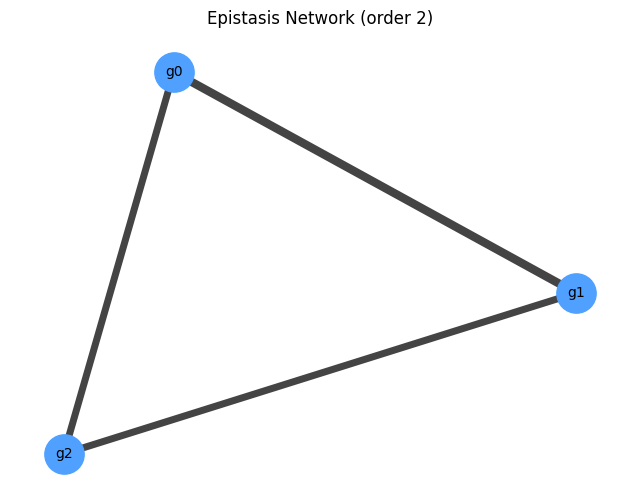

In [ ]:
edges = ep.epistasis_to_network(
    full_df,
    order=2,
    agg="mean_abs",
    feature_names=L.feature_names,
)

display(edges.head())

ep.plot_epistasis_network(edges, use_names=True)